# Import Packages

In [3]:
from PIL import Image #package to read image metadatas.
from PIL.ExifTags import TAGS  # Collection of name of image metadata and number associated with it
import pandas as pd
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import math as m
from sklearn.cluster import DBSCAN # clustering alogirthm
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits import mplot3d
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Path for Image Library

In [4]:
# Path where the photo to read is stored

path = '/Users/hiramani/Desktop/Python Practice/HeHe/Lawson re-fuel, sheen on Pine/'

files_image = [f for f in glob.glob(path + "*.JPG", recursive=True)] # Returns the list with path of the images with "JPG" extension based
file_names_image = [f.split('/')[-1] for f in files_image]  # Exact file names from the given path


# Define the data to be pulled from the image

In [5]:
# Initializing an empty dictionary
exif = {}
# Defining the required data to be extracted that - must match the standard in TAG
req_imgdata = ["ImageDescription",
               "DateTimeOriginal",
               "GPSInfo",
               "Make",
               "Model"]

# List for the column index for the dataframe
col_dataframe = ["Name", "Date", "Time", "DateTime", "Latitude", "Longitude", "Make", "Model"]

# Defining a dataframe
df_image = pd.DataFrame(columns=col_dataframe)

In [79]:
df_image

,Name,Date,Time,DateTime,Latitude,Longitude,Make,Model


# Define function to extract the defined data from each image file.

In [6]:
def getImageInfo(image, req_imgdata):
    """
    :param image: path of the image file who's metadata information is extracted
    :param req_imgdata: list of TAG of metadata to be extracted
    :return: list of value of TAG from the metadata

    """
    for tag, value in image._getexif().items():
        if tag in TAGS:
            exif[TAGS[tag]] = value  # Selects the tag in the image is present in the TAG in human readable format

    for key, value in exif.items():  # returns the dictionary as a list - looping over the list to get desired values
        if key in req_imgdata:  # Filtering the required parameters as given by "req_imgdata" variable
            if key == "ImageDescription":
                temp_name = value.split('\\')[-1]

            if key == "DateTimeOriginal":  # Extracting data and time from string to Data,Time and DateTime datatype
                temp_date = datetime.strptime(value[0:10], '%Y:%m:%d').date()
                temp_time = datetime.strptime(value[11:19], '%H:%M:%S').time()
                temp_date_time = datetime.strptime(value, '%Y:%m:%d %H:%M:%S')

            if key == "GPSInfo":  # Changing the dictionary GPS data into decimals
                if value[1][0] == "N": mul_lat = 1
                if value[1][0] == "S": mul_lat = -1
                if value[3][0] == "E": mul_lon = 1
                if value[3][0] == "W": mul_lon = -1
                #   Rounding the values of lat and long and changing N S to +ve and -ve cor-odrdinates
                temp_lat = round(value[2][0][0] + value[2][1][0] / 60 + value[2][2][0] / (3600 * value[2][2][1]),
                                 5) * mul_lat
                temp_lon = round(value[4][0][0] + value[4][1][0] / 60 + value[4][2][0] / (3600 * value[4][2][1]),
                                 5) * mul_lon

            if key == "Make":
                temp_make = value.rstrip('\x00')  # Stripping the non-required character

            if key == "Model":
                temp_model = value.rstrip('\x00')  # Stripping the non-required character

    temp_row = [temp_name, temp_date, temp_time, temp_date_time, temp_lat, temp_lon, temp_make, temp_model]
    return (temp_row)

# Read each image file and pass it to function above. Save the result obtained to a dataframe

In [7]:
for f in range(len(files_image)):
    try:
        img_file = files_image[f]  # Reading each file the list of files
        image = Image.open(img_file)  # Opening the image by passing the path of the image
        temp_list = getImageInfo(image, req_imgdata)
        df_image = df_image.append(pd.Series(temp_list, index=col_dataframe),
                       ignore_index=True)  # appending a dataframe in loop requires special treatment
    except IOError:
        pass

In [81]:
df_image

,Name,Date,Time,DateTime,Latitude,Longitude,Make,Model
0,DJI_0046.JPG,2017-09-05,17:47:17,2017-09-05 17:47:17,30.12919,-94.08853,DJI,FC6310
1,DJI_0052.JPG,2017-09-05,17:52:44,2017-09-05 17:52:44,30.13048,-94.08916,DJI,FC6310
2,DJI_0085.JPG,2017-09-05,18:17:05,2017-09-05 18:17:05,30.10851,-94.10349,DJI,FC6310
3,DJI_0090.JPG,2017-09-05,18:18:50,2017-09-05 18:18:50,30.10836,-94.10385,DJI,FC6310
4,DJI_0084.JPG,2017-09-05,18:17:01,2017-09-05 18:17:01,30.10851,-94.10349,DJI,FC6310
...,...,...,...,...,...,...,...,...
79,DJI_0076.JPG,2017-09-05,18:11:54,2017-09-05 18:11:54,30.10947,-94.10353,DJI,FC6310
80,DJI_0089.JPG,2017-09-05,18:18:48,2017-09-05 18:18:48,30.10836,-94.10385,DJI,FC6310
81,DJI_0088.JPG,2017-09-05,18:17:47,2017-09-05 18:17:47,30.10841,-94.10338,DJI,FC6310
82,DJI_0077.JPG,2017-09-05,18:11:58,2017-09-05 18:11:58,30.10947,-94.10353,DJI,FC6310


In [17]:
# adding columns to dataframe
df_image['Filename'] = file_names_image
# Sorting the dataframe as per time the photo was taken
df_image = df_image.sort_values(by=['DateTime']).reset_index(drop=True)  # Resetting the index after sorting as per date

# addiing columns to dataframe
df_image['Instances'] = np.arange(len(df_image.Name))+1
df_image['MediaType'] = "Image"
# print("Dataframe consisting of the list of the images")
# display(df) 
# Extracting the CSV file in the same folder as the data and names as ImageData.csv
df_image.to_csv(path+'ImageData.csv', index=False)
# df_image

,Name,Date,Time,DateTime,Latitude,Longitude,Make,Model,Filename,Instances,MediaType
0,DJI_0004.JPG,2017-09-05,16:31:11,2017-09-05 16:31:11,30.07554,-94.08473,DJI,FC6310,DJI_0046.JPG,1,Image
1,DJI_0005.JPG,2017-09-05,16:31:15,2017-09-05 16:31:15,30.07554,-94.08473,DJI,FC6310,DJI_0052.JPG,2,Image
2,DJI_0006.JPG,2017-09-05,16:31:33,2017-09-05 16:31:33,30.07559,-94.08498,DJI,FC6310,DJI_0085.JPG,3,Image
3,DJI_0008.JPG,2017-09-05,16:33:25,2017-09-05 16:33:25,30.07556,-94.08499,DJI,FC6310,DJI_0090.JPG,4,Image
4,DJI_0009.JPG,2017-09-05,16:33:30,2017-09-05 16:33:30,30.07556,-94.08499,DJI,FC6310,DJI_0084.JPG,5,Image
...,...,...,...,...,...,...,...,...,...,...,...
79,DJI_0004.JPG,2017-09-05,19:41:32,2017-09-05 19:41:32,30.10873,-94.10330,DJI,FC330,DJI_0076.JPG,80,Image
80,DJI_0006.JPG,2017-09-05,19:44:42,2017-09-05 19:44:42,30.10890,-94.10083,DJI,FC330,DJI_0089.JPG,81,Image
81,DJI_0007.JPG,2017-09-05,19:44:49,2017-09-05 19:44:49,30.10890,-94.10083,DJI,FC330,DJI_0088.JPG,82,Image
82,DJI_0008.JPG,2017-09-05,19:44:52,2017-09-05 19:44:52,30.10890,-94.10083,DJI,FC330,DJI_0077.JPG,83,Image


In [55]:
# type(df_image['Instances'])
type(df_image['DateTime'])
# len(df_image['DateTime'])

pandas.core.series.Series

# Plotting the data with Time vs Instance

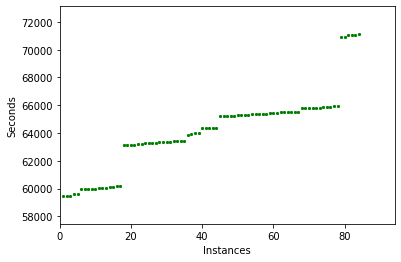

In [144]:
df_image['Time_Seconds']=[df_image.Time[f].hour*3600+df_image.Time[f].minute*60+df_image.Time[f].second for f in range(len(df_image['Time']))]


y_major_minutes = 30 #set the major tick marks at 30 minutes.
y_minor_seconds = y_major_minutes * 60 #minor tick at seconds.
y_min_value = m.floor(((min(df_image.Time).hour*3600+min(df_image.Time).minute*60+min(df_image.Time).second)/y_minor_seconds)*y_minor_seconds)
y_max_value = m.ceil(((max(df_image.Time).hour*3600+max(df_image.Time).minute*60+max(df_image.Time).second)/y_minor_seconds)*y_minor_seconds)

plt.axis([0,len(df_image['Instances'])+10,y_min_value-2000,y_max_value+2000])
plt.scatter(df_image['Instances'],df_image['Time_Seconds'],marker='x',s=5,c='g')
plt.xlabel('Instances')
plt.ylabel('Seconds')
# df_image.plot('Instances','Time_Seconds',kind='scatter')
plt.show()

In [112]:
df_image

,Name,Date,Time,DateTime,Latitude,Longitude,Make,Model,Filename,Instances,MediaType,Time_Seconds
0,DJI_0004.JPG,2017-09-05,16:31:11,2017-09-05 16:31:11,30.07554,-94.08473,DJI,FC6310,DJI_0046.JPG,1,Image,59471
1,DJI_0005.JPG,2017-09-05,16:31:15,2017-09-05 16:31:15,30.07554,-94.08473,DJI,FC6310,DJI_0052.JPG,2,Image,59475
2,DJI_0006.JPG,2017-09-05,16:31:33,2017-09-05 16:31:33,30.07559,-94.08498,DJI,FC6310,DJI_0085.JPG,3,Image,59493
3,DJI_0008.JPG,2017-09-05,16:33:25,2017-09-05 16:33:25,30.07556,-94.08499,DJI,FC6310,DJI_0090.JPG,4,Image,59605
4,DJI_0009.JPG,2017-09-05,16:33:30,2017-09-05 16:33:30,30.07556,-94.08499,DJI,FC6310,DJI_0084.JPG,5,Image,59610
...,...,...,...,...,...,...,...,...,...,...,...,...
79,DJI_0004.JPG,2017-09-05,19:41:32,2017-09-05 19:41:32,30.10873,-94.10330,DJI,FC330,DJI_0076.JPG,80,Image,70892
80,DJI_0006.JPG,2017-09-05,19:44:42,2017-09-05 19:44:42,30.10890,-94.10083,DJI,FC330,DJI_0089.JPG,81,Image,71082
81,DJI_0007.JPG,2017-09-05,19:44:49,2017-09-05 19:44:49,30.10890,-94.10083,DJI,FC330,DJI_0088.JPG,82,Image,71089
82,DJI_0008.JPG,2017-09-05,19:44:52,2017-09-05 19:44:52,30.10890,-94.10083,DJI,FC330,DJI_0077.JPG,83,Image,71092


In [145]:
!conda list seaborn

# packages in environment at /opt/anaconda3:
#
# Name                    Version                   Build  Channel
seaborn                   0.10.0                     py_0  


In [146]:
!which python

/opt/anaconda3/bin/python
